In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_ecg(signal, fs=360, label=None, pid=None, idx=None, show_grid=True):
    """
    Plot a single ECG beat segment in the style of clinical ECG reports.
    
    Args:
        signal (1D numpy array): ECG segment
        fs (int): Sampling frequency
        label (str): Beat annotation label
        pid (str): Patient ID
        idx (int): Index of the beat
        show_grid (bool): Whether to show ECG-style grid
    """
    duration = len(signal) / fs
    time = np.linspace(0, duration, len(signal))

    plt.figure(figsize=(10, 3))
    plt.plot(time, signal, color='black', linewidth=1)
    plt.title(f"ECG Beat (label={label}, patient={pid}, idx={idx})", fontsize=14)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (mV)")
    
    # Grid for ECG look
    if show_grid:
        plt.grid(which='major', color='lightcoral', linestyle='--', linewidth=0.5)
        plt.minorticks_on()
        plt.grid(which='minor', color='lightgrey', linestyle=':', linewidth=0.3)
    
    plt.tight_layout()
    plt.show()


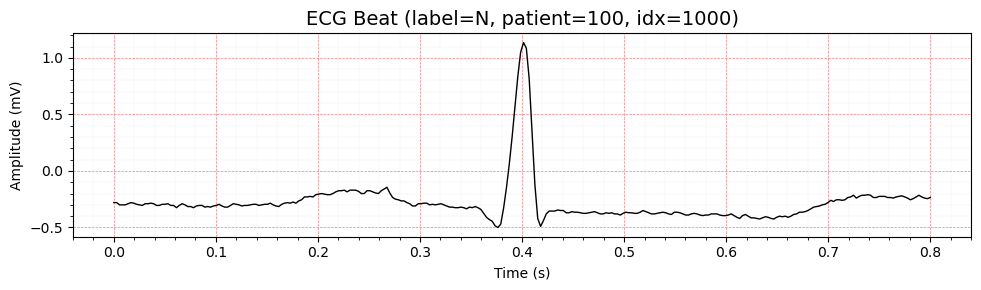

In [4]:
# Load data
base_path = "../data/processed/mit_bih"
data = np.load(os.path.join(base_path, "data.npy"))
labels = np.load(os.path.join(base_path, "label.npy"))
pids = np.load(os.path.join(base_path, "pid.npy"))

# Pick an index to visualize
i = 1000

signal = data[i]
label = labels[i]
pid = pids[i]
fs = 360
# Plot ECG
plot_ecg(signal, fs=fs, label=label, pid=pid, idx=i)


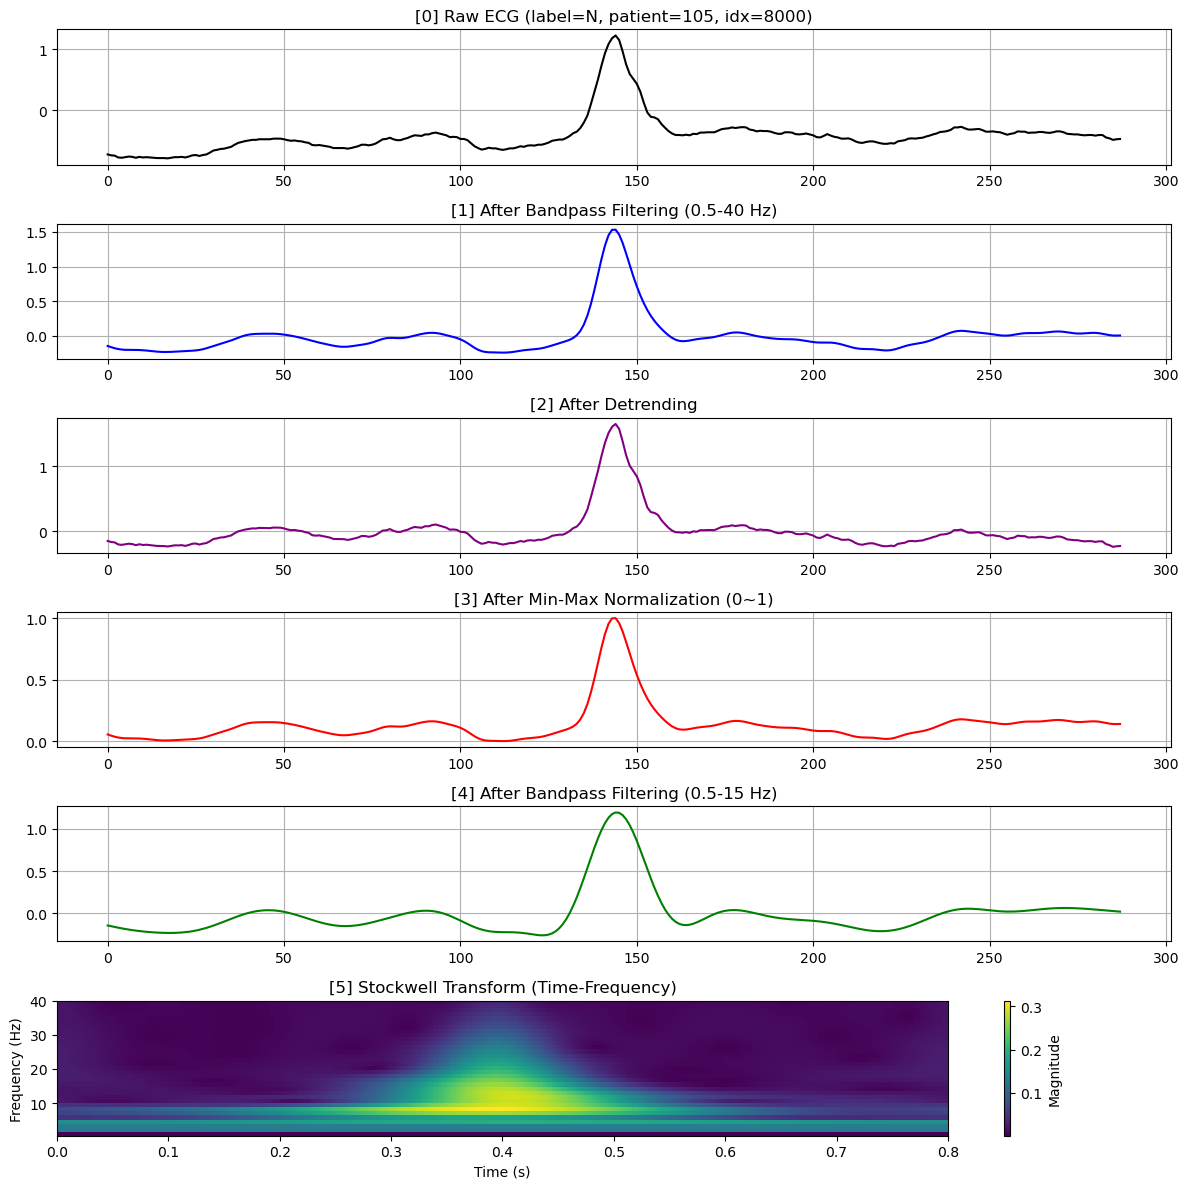

In [4]:
import ecg_pipeline

# Pick an index to visualize
i = 8000

signal = data[i]
label = labels[i]
pid = pids[i]

# Apply preprocessing steps sequentially
signal_bandpassed = ecg_pipeline.bandpass_filter(signal, fs)
signal_detrended = ecg_pipeline.detrend_signal(signal)
signal_standardized = ecg_pipeline.standardize_signal(signal_bandpassed)
signal_15Hz = ecg_pipeline.bandpass_filter(signal, fs, lowcut=0.5, highcut=15)

st_result, freqs, times = ecg_pipeline.stockwell_transform(signal_bandpassed, fs, fmin=0.5, fmax=40)

# Plot all stages
x_samples = np.arange(len(signal))

fig, axs = plt.subplots(6, 1, figsize=(12, 12), sharex=False)

axs[0].plot(x_samples, signal, color='black')
axs[0].set_title(f"[0] Raw ECG (label={label}, patient={pid}, idx={i})")

axs[1].plot(x_samples, signal_bandpassed, color='blue')
axs[1].set_title("[1] After Bandpass Filtering (0.5-40 Hz)")

axs[2].plot(x_samples, signal_detrended, color='purple')
axs[2].set_title("[2] After Detrending")

axs[3].plot(x_samples, signal_standardized, color='red')
axs[3].set_title("[3] After Min-Max Normalization (0~1)")

axs[4].plot(x_samples, signal_15Hz, color='green')
axs[4].set_title("[4] After Bandpass Filtering (0.5-15 Hz)")

# Stockwell Transform Visualization
im = axs[5].imshow(np.abs(st_result), aspect='auto', origin='lower',
                   extent=(times[0], times[-1], freqs[0], freqs[-1]),
                   cmap='viridis')
axs[5].set_title("[5] Stockwell Transform (Time-Frequency)")
axs[5].set_ylabel("Frequency (Hz)")
axs[5].set_xlabel("Time (s)")

cbar = plt.colorbar(im, ax=axs[5])
cbar.set_label("Magnitude")

for ax in axs[:-1]:
    ax.grid(True)

plt.tight_layout()
plt.show()
